# Training image classifier
We perform transfer learning on ResNet50 with Keras to classify images on the labels listed in `'cuisines'`.

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load dataframe
df = pd.read_csv('labels_balanced.csv')

# Change 'image_id' to string and add '.jpg' to the end
df['image_id'] = df['image_id'].astype(str)

# Split dataframe into train, validation, and test sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=0)
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=0)

### Preprocess image data
First we preprocess the image data. For the image augmentation, we rescale the images by 1/255, apply a shear range of 0.2, zoom range of 0.2, and horizontal flip. This is done for both train and test data.
Next, we create batches of augmented images of size 32. `class_mode` is set to `categorical` since we have multiple classes.

In [6]:
# Set batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 50

# Create data augmentation instance for train set with ImageDataGenerator
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
)

# Create batches of augmented images from trainset
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='./images',
    x_col='image_id',
    y_col='price_category',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Create data augmentation instance for test set with ImageDataGenerator
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create batches of augmented images from testset
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='./images',
    x_col='image_id',
    y_col='price_category',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Create data augmentation instance for test set with ImageDataGenerator
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create batches of augmented images from testset
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='./images',
    x_col='image_id',
    y_col='price_category',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 15687 validated image filenames belonging to 4 classes.
Found 4358 validated image filenames belonging to 4 classes.
Found 1743 validated image filenames belonging to 4 classes.


(64, 224, 224, 3)


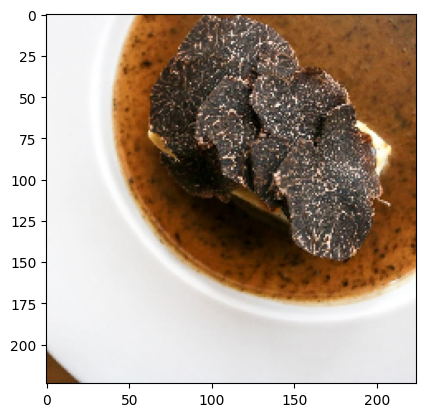

(64, 224, 224, 3)


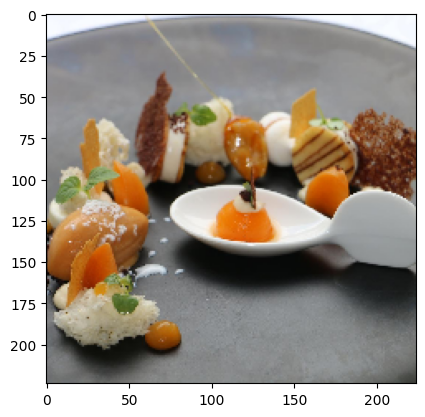

(64, 224, 224, 3)


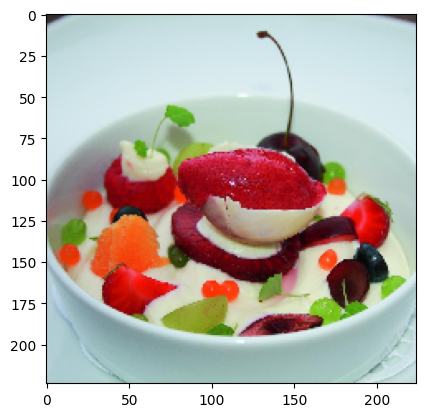

(64, 224, 224, 3)


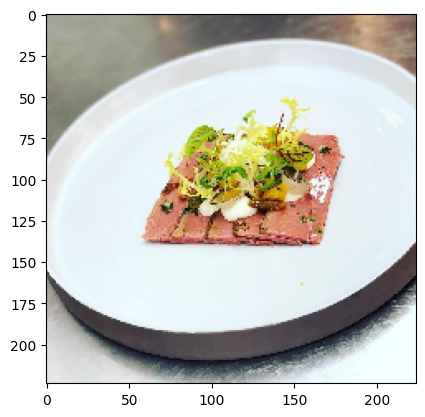

(64, 224, 224, 3)


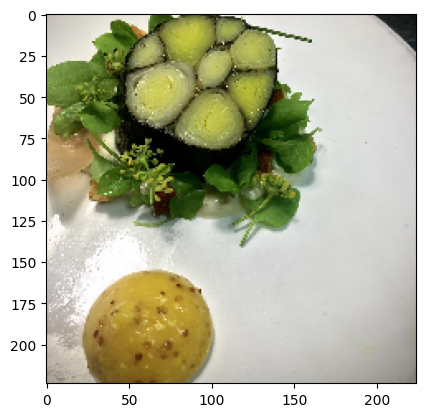

In [7]:
import matplotlib.pyplot as plt

for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Create model
Load ResNet50v2 model with pretrained ImageNet weights and add a few new layers to finetune with our dataset. Reduce dimensions of the base model with a global average pooling layer and then add a fully connected layer with 1024 units and ReLU activation. Then create the final layer with the number of classes that is uses softmax activation to make classifications.

In [8]:
# Load ResNet50 model
base_model = ResNet50(include_top=False, weights='imagenet')

# Add new layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Define new model
model = Model(inputs=base_model.input, outputs=predictions)

Freeze the layers in the base model so they don't get overwritten, and then compile the model with Adam optimizer and categorical crossentropy loss.

In [9]:
# Freeze each layer in the model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Define callbacks to save the best model and stop training early if the validation loss doesn't improve after 10 epochs.

In [11]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Calculate steps per epoch
n_steps = train_generator.samples // BATCH_SIZE

# Plot loss
plot_loss = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint = ModelCheckpoint(filepath='model-food-price_noaugment.best.hdf5',
                                save_best_only=True,
                                verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

### Train model

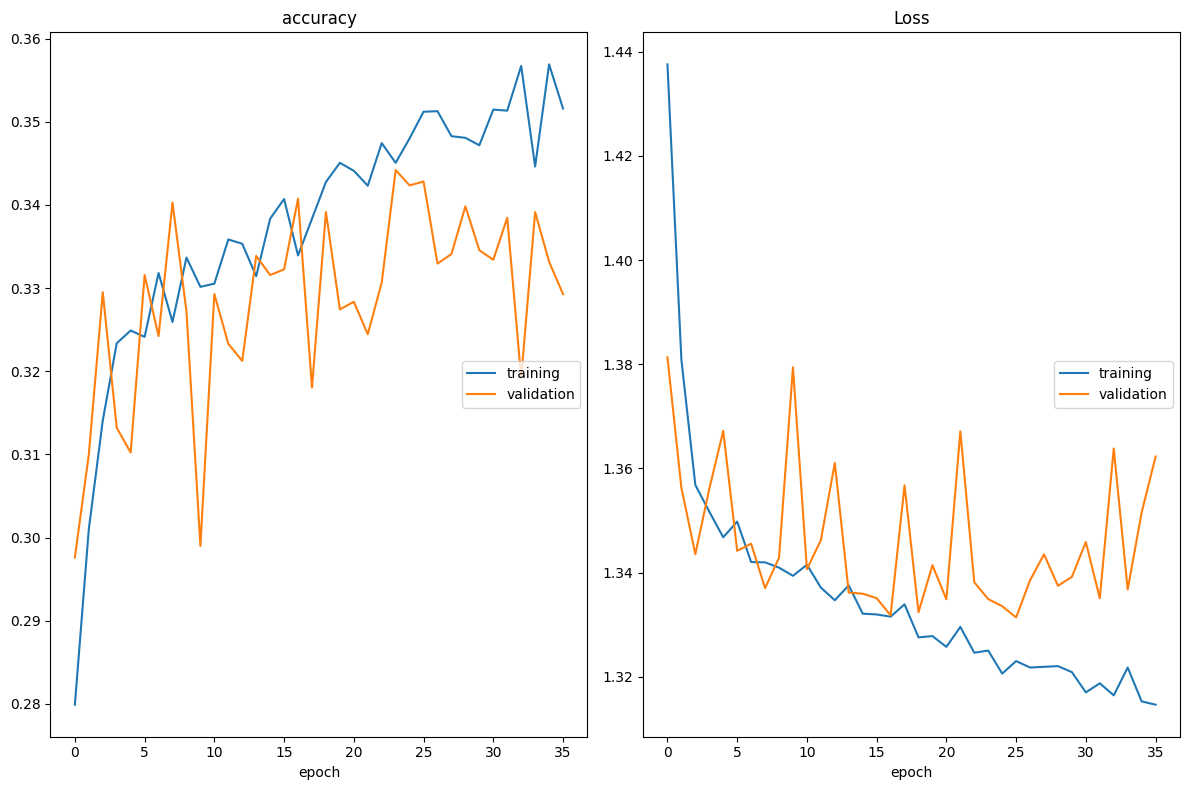

accuracy
	training         	 (min:    0.280, max:    0.357, cur:    0.352)
	validation       	 (min:    0.298, max:    0.344, cur:    0.329)
Loss
	training         	 (min:    1.315, max:    1.438, cur:    1.315)
	validation       	 (min:    1.331, max:    1.381, cur:    1.362)
245/245 [==============================] - 136s 557ms/step - loss: 1.3147 - accuracy: 0.3516 - val_loss: 1.3623 - val_accuracy: 0.3293


In [12]:
# Train model
model.fit(
    train_generator, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=n_steps,
    validation_data=val_generator,
    callbacks=[tl_checkpoint, early_stop, plot_loss]
    )

In [13]:
# Load best weights
model.load_weights('model-food-price_noaugment.best.hdf5')

# Accuracy and loss of best checkpoint
model.evaluate(train_generator)
model.evaluate(val_generator)
model.evaluate(test_generator)

28/28 [==============================] - 13s 477ms/step - loss: 1.3235 - accuracy: 0.3563


[1.32353675365448, 0.3562822639942169]

In [14]:
# Save model
model.save('price-classifier-food_resnet50_noaugment.h5')